### Windsat training   
Training notebook with windsat dataset, to experiment with model architecture, sample selection an hyperparameters.

In [35]:
import matplotlib.pyplot as plt
import pickle

from datetime import datetime
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model, load_model
import sys
sys.path.append("../../")

from src.processing import windsat_datacube, model_preprocess
from src.model import transform_batch, xy_split, plot_history

In [36]:
#Load the dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 121kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 60kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [37]:
# Preprocess and select the dataset
ascds = model_preprocess(ds)
ascds

<xarray.Dataset> Size: 784MB
Dimensions:         (day_number: 21, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

# Create the training dataset
Trust xarray and load all the data into a dataframe for training with keras


In [38]:
ascds_df = ascds.to_dataframe()
ascds_df.reset_index(inplace=True)
ascds_df.dropna(inplace=True)
ascds_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
ascds_df = transform_batch(ascds_df)
# Experimental: remove day number from training, It does not seem to have an effect on training (with 21 days)
# ascds_df.drop(columns = ["day_number"], inplace = True)
ascds_df

,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz
212694,0.017166,275.894440,-0.799947,0.959437,194.885010,127.485001,215.657501,163.107498,-0.498066,-0.498753
232835,0.017166,276.849609,-0.761821,0.932796,211.529999,159.434998,230.509995,191.927490,-0.502751,-0.503454
232838,0.017166,277.820099,-0.761821,0.937434,218.139999,172.832489,234.354996,200.334991,-0.502524,-0.503216
232839,0.017166,278.050476,-0.761821,0.938944,217.937500,172.014999,234.285004,199.912506,-0.502455,-0.503140
232840,0.017166,277.954346,-0.761821,0.940437,213.382492,163.179993,231.119995,193.644989,-0.502389,-0.503071
...,...,...,...,...,...,...,...,...,...,...
21661288,0.352752,276.515686,0.943368,0.376629,202.862488,140.917496,215.862503,169.722504,-0.745851,-0.746355
21661289,0.352752,275.758698,0.943368,0.380667,208.297485,151.820007,217.259995,175.607498,-0.745832,-0.746333
21705886,0.352752,275.418823,0.979487,0.201505,196.614990,127.227493,208.505005,153.690002,-0.752623,-0.753145
21705887,0.352752,275.177582,0.979487,0.205777,196.882492,127.707497,208.345001,153.547501,-0.752609,-0.753126


In [39]:
# Define a custom model to train:
def build_model(n_vars):
    model = Sequential([
        Input((n_vars,)),
        BatchNormalization(),
        Dense(30,activation="linear", name = "hiddenLayer1"),
        Dense(20,activation="relu", name = "hiddenLayer2"),
        Dense(10,activation="relu", name = "hiddenLayer3"),
        Dense(1,activation="relu", name = "outputLayer")
    ])
    model.compile(
        optimizer = Adam(learning_rate = 0.014570815050621676 ),
        loss ="mse",
        metrics = ["mse"]
    )

    model.summary()

    return model

# best_params = {'n_neurons': 20, 'n_hidden': 1, 'learning_rate': 0.014570815050621676}

n_vars = ascds_df.shape[1] - 1
model =build_model(n_vars)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177 (4.60 KB)

 Trainable params: 1,159 (4.53 KB)

 Non-trainable params: 18 (72.00 B)

In [41]:
# Pick the columns for training and test
X, y = xy_split(ascds_df)
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 13)

# Fit the model
callback = EarlyStopping(
    monitor = "loss",
    patience = 3,
    min_delta = 0.1,
    verbose=2,
    restore_best_weights = True
)

checkpoints = ModelCheckpoint(
    filepath="../../models/checkpoint.weights.h5",
    save_weights_only= True,
    verbose = 1
)

history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size = 128,
    validation_data=(x_test,y_test),
    callbacks=[callback, checkpoints]
)


Epoch 1/100
 561/3128 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 17.2174 - mse: 17.2174

In [44]:
now = datetime.now().strftime(r"%Y_%m_%dT%H%M%S")

# Save FINAL model weights and history data.
model_path = f"../../models/{now}.keras"
save_model(model, model_path)

# Save training history
history_path = f"../../models/{now}_history"
with open(history_path,"wb") as hfile:
    pickle.dump(history.history, hfile)


(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='mse [K]'>,
        <Axes: title={'center': 'Last 10 epochs'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

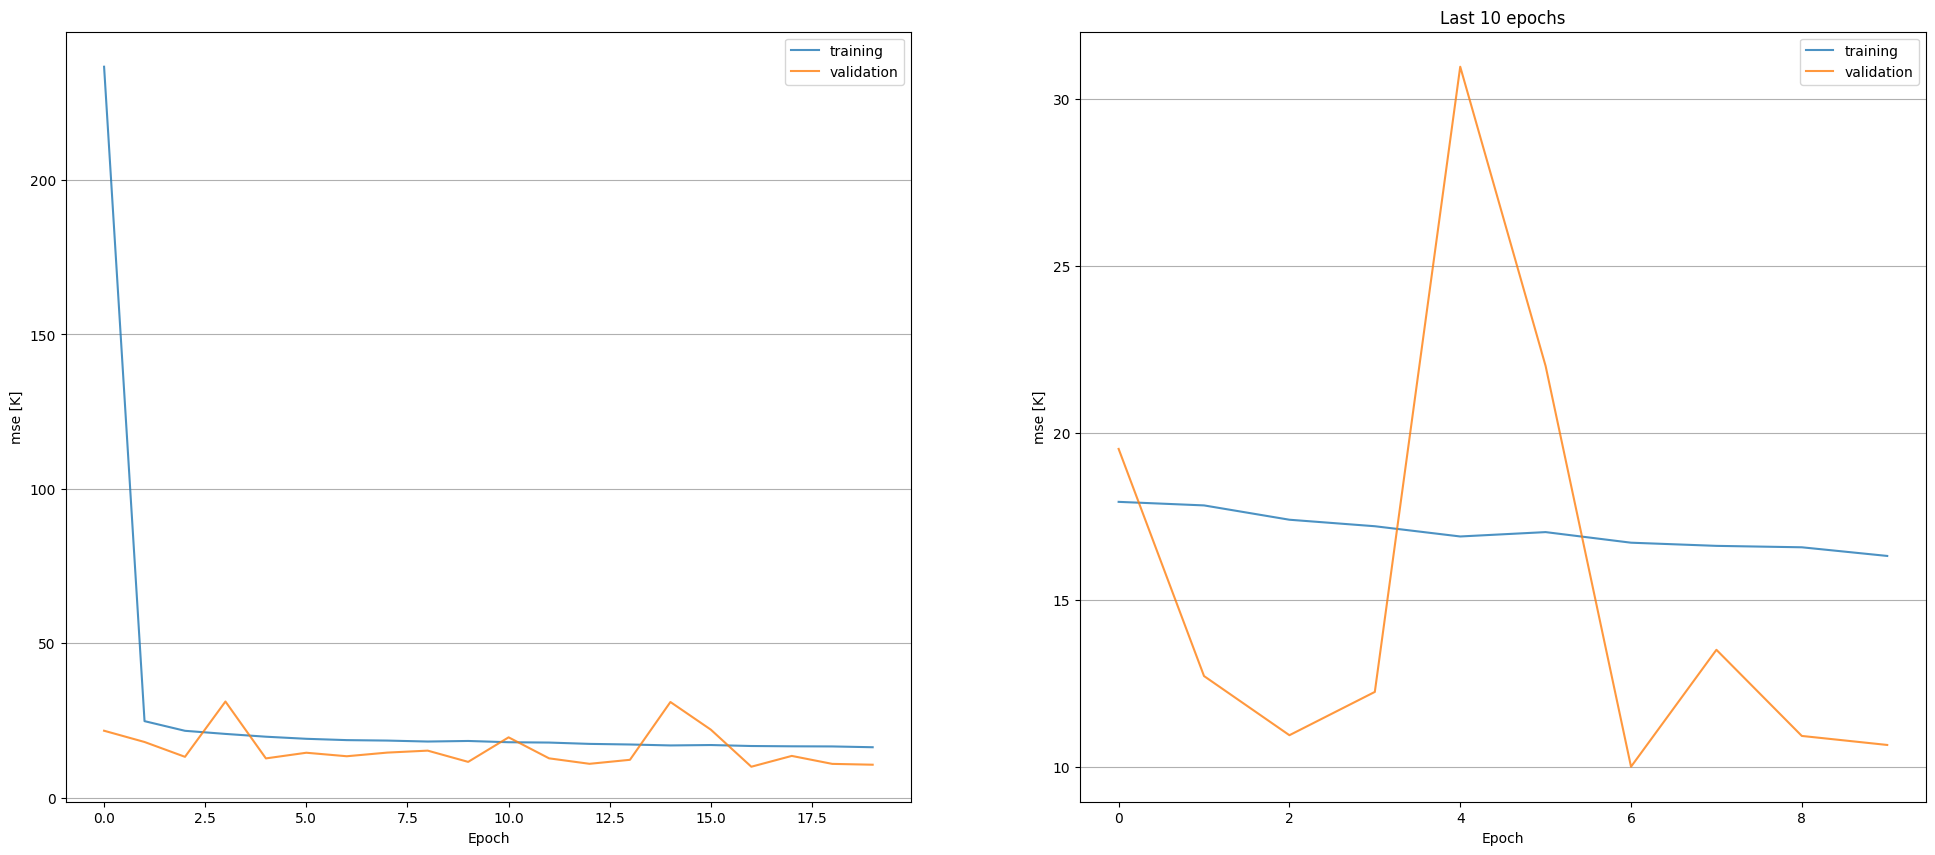

In [7]:
# Check the loading of the history file works
with open(history_path,"rb") as hfile:
    history = pickle.load(hfile)
    
plot_history(history)

# Notes

The model trains and the visualization is kind of nice. I need to run it with the full dataset.

My intuition is that we are not capturing the influence of day_number yet, since we only have 21 days (local dataset is biased)

--- 

In [1]:
# Add DEM to the training data to see if the performance increases at all
import xarray as xr
dem_path = '../../data/processed/resampled_ETOPO2V2c.nc'
dem_ds = xr.open_dataset(dem_path)
dem_ds

<xarray.Dataset> Size: 17MB
Dimensions:   (y: 720, x: 1440)
Coordinates:
  * x         (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * y         (y) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Data variables:
    z         (y, x) float64 8MB ...
    landmask  (y, x) float64 8MB ...
Attributes:
    Conventions:  COARDS
    title:        
    source:                               -Rd -I2m -ZTLf                     ...
    node_offset:  1

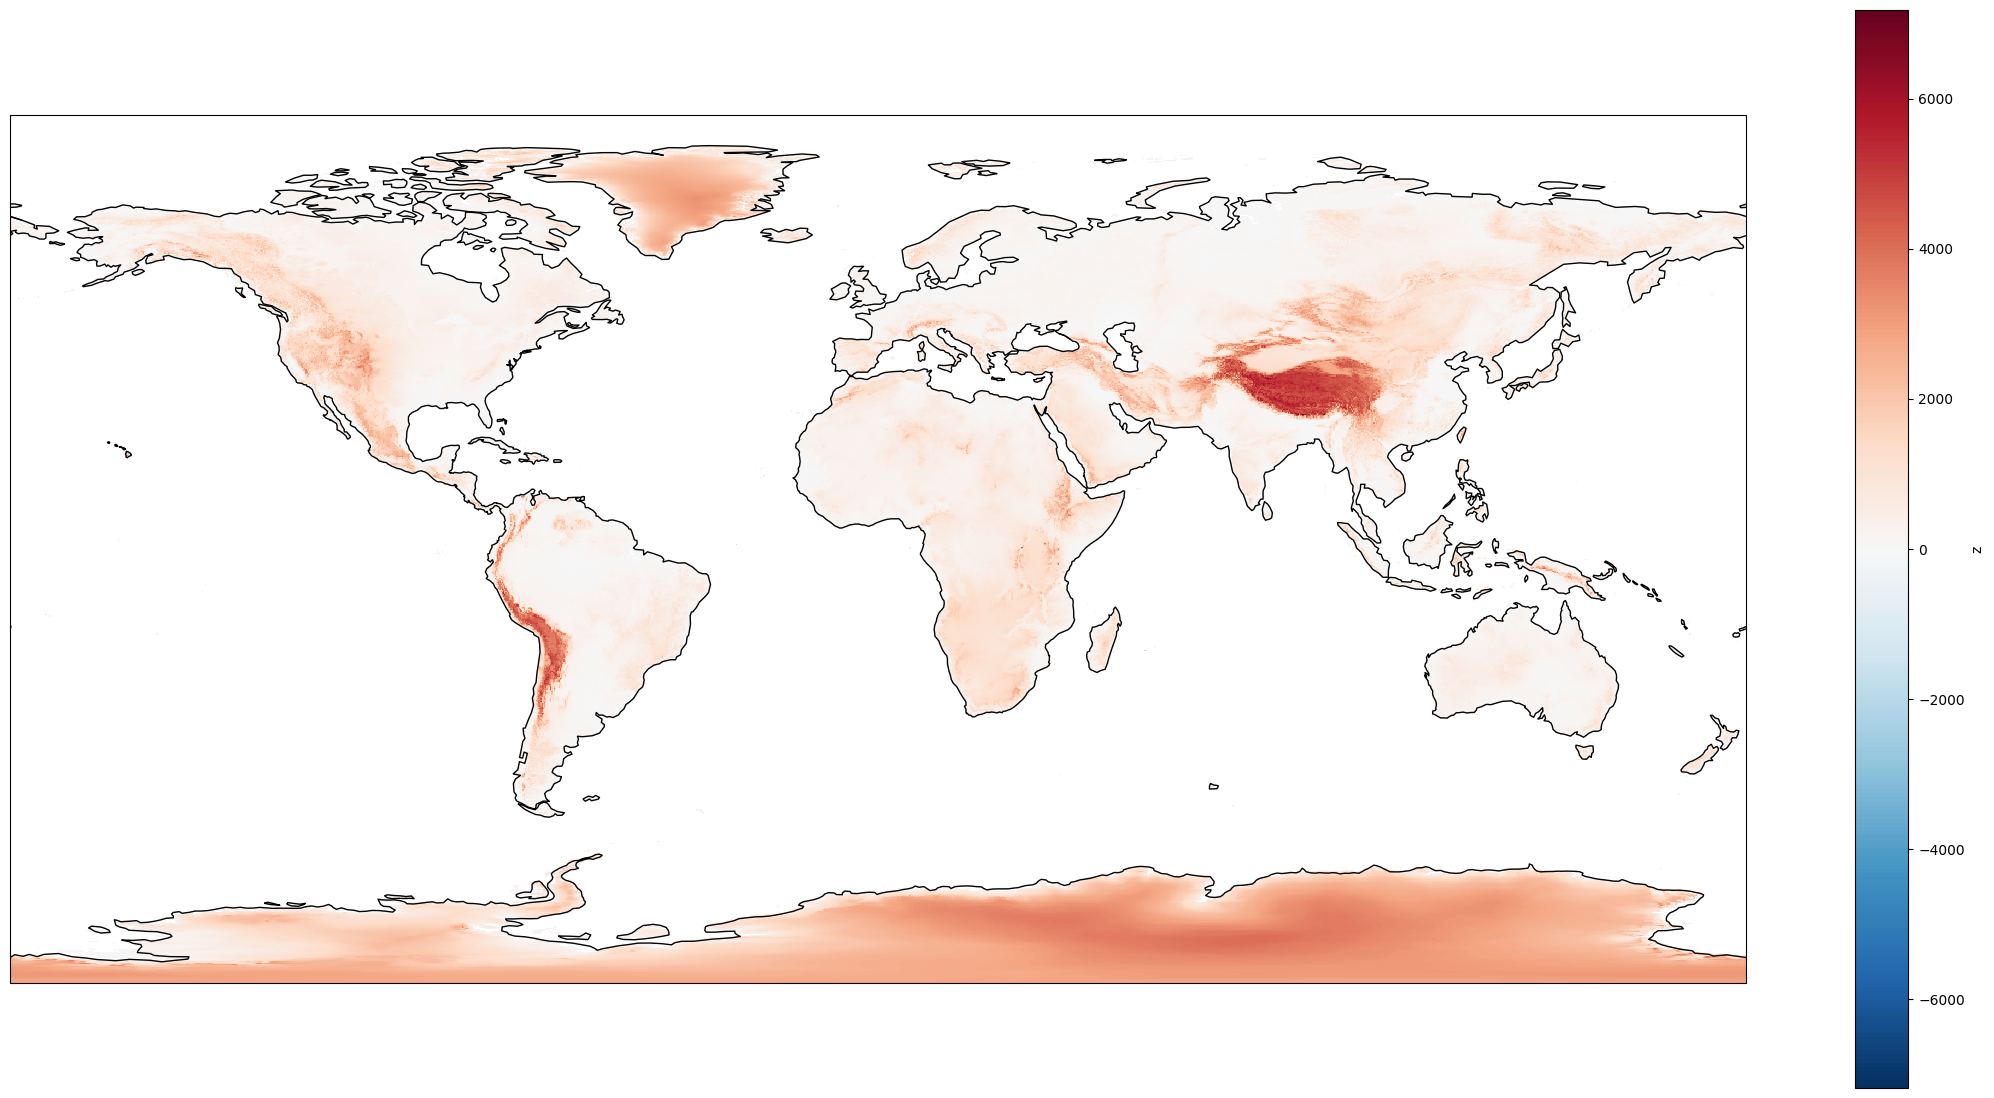

In [4]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize = (28,14), subplot_kw={"projection": ccrs.PlateCarree()})
dem_ds.z.plot(ax=ax)
ax.coastlines("110m")

In [11]:
#Load the dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)

# Preprocess and select the dataset
ascds = model_preprocess(ds)

# Add the z value to the training data
ascds["z"] = (("latitude_grid","longitude_grid"), dem_ds.z.values)

ascds


<xarray.Dataset> Size: 792MB
Dimensions:         (day_number: 21, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    z               (latitude_grid, longitude_grid) float64 8MB 2.78e+03 ... nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [25]:
# Continue processing the data into a dataframe:
ascds_df = ascds.to_dataframe()
ascds_df.reset_index(inplace=True)
ascds_df.dropna(inplace=True)
ascds_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
ascds_df = transform_batch(ascds_df)
# Experimental: remove day number from training, It does not seem to have an effect on training (with 21 days)
# ascds_df.drop(columns = ["day_number"], inplace = True)

# Not great the first time, try transforming the z value so its normalised (?)

ascds_df["z"] = ascds_df["z"] - ascds_df["z"].min() /(ascds_df["z"].max() - ascds_df["z"].min())
ascds_df

,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,z
317268,0.017166,295.947784,-0.571788,-0.890014,261.809998,229.057495,265.390015,239.684998,-0.371622,-0.370879,182.158072
317269,0.017166,296.286652,-0.571788,-0.888016,263.989990,233.337494,266.937500,243.009995,-0.371726,-0.370994,22.657328
317270,0.017166,296.380768,-0.571788,-0.886001,268.919983,243.687500,270.785004,251.587494,-0.371838,-0.371092,85.407500
317271,0.017166,296.155853,-0.571788,-0.883970,270.977478,248.107498,272.459991,255.327484,-0.371925,-0.371196,100.156641
317272,0.017166,295.905670,-0.571788,-0.881921,272.209991,251.154999,273.607483,257.529999,-0.372027,-0.371291,108.408758
...,...,...,...,...,...,...,...,...,...,...,...
21648298,0.352752,275.231079,0.929616,0.252492,209.255005,155.292496,220.782501,178.447495,-0.745425,-0.745938,141.406699
21655512,0.352752,275.351440,0.937434,0.311091,212.657501,160.577499,223.777496,187.592499,-0.745570,-0.746062,36.031556
21658396,0.352752,275.671509,0.940437,0.327630,210.962494,156.227493,219.137497,177.000000,-0.745781,-0.746280,31.032013
21661288,0.352752,276.515686,0.943368,0.376629,202.862488,140.917496,215.862503,169.722504,-0.745851,-0.746355,22.031212


In [26]:
# Build the model again, same architecture + 1 input
model =build_model(ascds_df.shape[1] - 1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,211 (4.73 KB)

 Trainable params: 1,191 (4.65 KB)

 Non-trainable params: 20 (80.00 B)

Epoch 1/100
3079/3117 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 7090.6768 - mse: 7090.6768
Epoch 1: saving model to ../../models/checkpoint.weights.h5
3117/3117 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 7019.7109 - mse: 7019.7109 - val_loss: 19.7697 - val_mse: 19.7697
Epoch 2/100
3092/3117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.4939 - mse: 31.4939
Epoch 2: saving model to ../../models/checkpoint.weights.h5
3117/3117 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 31.4884 - mse: 31.4884 - val_loss: 103.5976 - val_mse: 103.5976
Epoch 3/100
3116/3117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.9420 - mse: 31.9420
Epoch 3: saving model to ../../models/checkpoint.weights.h5
3117/3117 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 31.9410 - mse: 31.9410 - val_loss: 44.0418 - val_mse: 44.0418
Epoch 4/100
3083/3117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.2893 - mse: 30.2893
Epoch 4: saving model to ../../models/checkpoint.weights.h5
3117/3117 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 30.2818 - mse:

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='mse [K]'>,
        <Axes: title={'center': 'Last 16 epochs'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

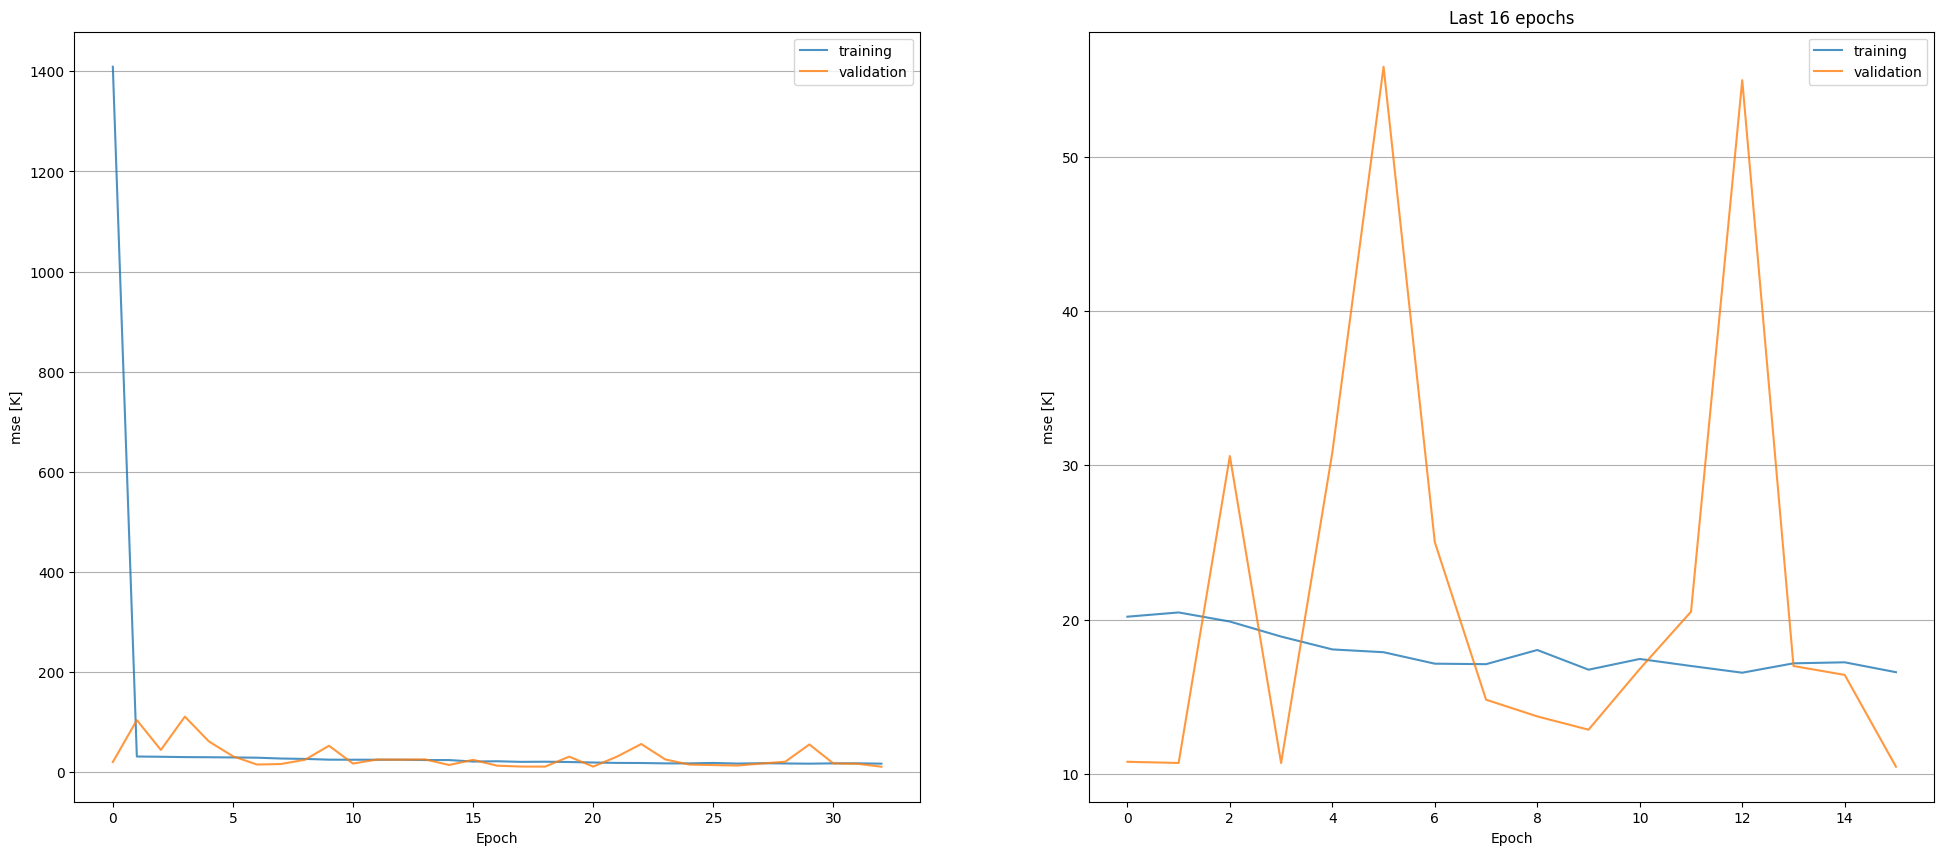

In [27]:
# Train on the local dataset:
X, y = xy_split(ascds_df)
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 13)

# Fit the model
callback = EarlyStopping(
    monitor = "loss",
    patience = 3,
    min_delta = 0.1,
    verbose=2,
    restore_best_weights = True
)

checkpoints = ModelCheckpoint(
    filepath="../../models/checkpoint.weights.h5",
    save_weights_only= True,
    verbose = 1
)

history = model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_data=(x_test,y_test),
    callbacks=[callback, checkpoints]
)
plot_history(history.history)